waypoints  [[1.7722995  0.99922979]
 [8.4792875  3.34436492]
 [3.77693695 4.23402773]
 [1.77947493 5.20385449]
 [9.85695902 0.04877472]
 [9.34703168 2.01094627]
 [9.94105299 4.01940548]
 [4.7490199  2.25752586]
 [8.76803835 1.01958655]
 [3.95402971 7.42792144]]
add_nodes
G  Graph with 11 nodes and 53 edges
Edges [(0, 8, {'weight': 13.87640772411303}), (0, 1, {'weight': 1.9961941942292603}), (0, 3, {'weight': 15.87618590283677}), (0, 9, {'weight': 15.880500506971588}), (0, 2, {'weight': 16.877006835570484}), (0, 6, {'weight': 16.875495562443216}), (0, 5, {'weight': 16.88056173026923}), (0, 4, {'weight': 17.872946912959982}), (0, 7, {'weight': 18.87227894411}), (0, 10, {'weight': 15.838508728225506}), (1, 8, {'weight': 14.879248424180084}), (1, 3, {'weight': 15.875160141736089}), (1, 4, {'weight': 15.882077364462647}), (1, 10, {'weight': 16.831292490526067}), (1, 9, {'weight': 18.877934164695137}), (1, 2, {'weight': 6.987064403743318}), (1, 6, {'weight': 19.873070173538743}), (1, 5, {'we

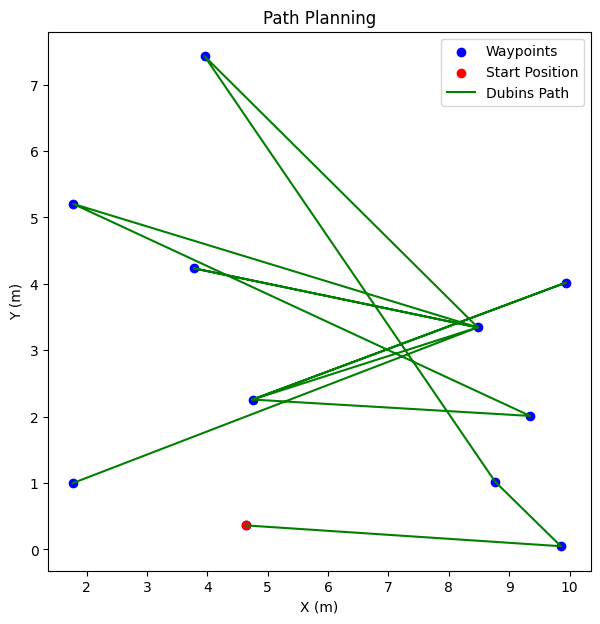

Path Length: 239.65 meters
Path Time: 239.65 seconds


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import math
# from dubins import path_sample
from dubins import shortest_path
import networkx as nx
from scipy.spatial import distance_matrix
import dubins
from scipy.spatial import distance
from scipy.spatial import KDTree



class PathPlanner:
    def __init__(self, area_size=10, num_points=10, cluster_percentage=0, cluster_std=3, min_turning_radius=2 , k_nearest_neighbors=10):
        self.area_size = area_size
        self.num_points = num_points
        self.cluster_percentage = cluster_percentage
        self.cluster_std = cluster_std
        self.min_turning_radius = min_turning_radius
        self.robot_start_pos = None
        self.waypoints = None
        self.path_length = None
        self.path_time = None
        self.k_nearest_neighbors = k_nearest_neighbors
        # Initialize graph
        self.G = nx.Graph()


    def generate_random_points(self):
        '''Generate random waypoints in the area'''
        self.waypoints = np.random.uniform(0, self.area_size, (self.num_points, 2))


    def add_clusters(self):
        '''Add clusters of waypoints around specific points'''
        num_clusters = int(self.num_points * self.cluster_percentage)
        cluster_indices = np.random.choice(range(self.num_points), num_clusters, replace=False)

        for idx in cluster_indices:
            num_plants = np.random.randint(2,5)
            cluster_center = self.waypoints[idx]
            plants_x = np.random.normal(cluster_center[0], self.cluster_std, num_plants)
            plants_y = np.random.normal(cluster_center[1], self.cluster_std, num_plants)
            cluster_points = np.column_stack((plants_x, plants_y))
            # print(f"Generated {num_plants} cluster points around {cluster_center}")
            # print(cluster_points)
            self.waypoints = np.concatenate((self.waypoints, cluster_points))
        

    def assign_start_position(self):
        '''Assign a random start position for the robot'''
        self.robot_start_pos = np.random.uniform(0, self.area_size, 2)
 
    def dubins_path_length(self, start, end, turning_radius):
        '''Calculate the length of the Dubins path between two points'''
        configurations = (start[0], start[1], 0), (end[0], end[1], 0)
        path= shortest_path(configurations[0], configurations[1], self.min_turning_radius)
        samples= path.sample_many(1.0)[0]
        # samples = self.calculate_dubins_path(start, end)
        if samples:
            length = sum(distance.euclidean(samples[i][:2], samples[i+1][:2]) for i in range(len(samples)-1))
            return length
        return float('inf')  # Return a large number if path is infeasible

        
    def calculate_dubins_path(self, start, end):
        '''Calculate the Dubins path between two points'''
        configurations = (start[0], start[1], 0), (end[0], end[1], 0)
        path= shortest_path(configurations[0], configurations[1], self.min_turning_radius)
        samples= path.sample_many(1.0)[0]
        # print("sample " , samples)
        return np.array(samples)
    
    def calculate_angle(self,current_waypoint, next_waypoint):
    # Calculate the direction to the waypoint
        direction_to_waypoint = math.atan2(next_waypoint[1] - current_waypoint[1],next_waypoint[0]
                                           - current_waypoint[0])
        current_angle = 0 # Assuming the robot is facing in the positive x-direction
        # Calculate the angle between the robot's heading and the direction to the waypoint
        angle = math.degrees(direction_to_waypoint - current_angle)

        # Normalize the angle to the range [-180, 180]
        angle = (angle + 180) % 360 - 180

        return angle
    def is_reachable(self, current_waypoint, next_waypoint):
        # Calculate the distance to the waypoint
        distance = math.sqrt((next_waypoint[1]- current_waypoint[1])**2 + (next_waypoint[0] - current_waypoint[0])**2)

        angle = self.calculate_angle(current_waypoint, next_waypoint)
        # print("dis ",angle ,  current_waypoint , next_waypoint , distance)
 
        # Check if the angle is within the robot's steering limits
        if angle > 45 or angle < -45:
            if distance > 2*self.min_turning_radius  :
                return True
            else:
                return False

        return True

    def calculate_path_length(self, path):
        '''Calculate the length of the path'''

        self.path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
        self.path_time = self.path_length / 1  # Assuming constant velocity of 1 m/s
    def add_nodes(self, nodes):

        # Add nodes to the graph
        print("add_nodes")
        self.waypoints = np.insert(self.waypoints, 0, self.robot_start_pos, axis=0)  # Insert start position as the first node       
        for i, node in enumerate(self.waypoints):
            self.G.add_node(i, pos=(node[0], node[1]))
    def add_edges(self):
        # Add edges to the graph with Dubins path lengths
        print("add_edges")
        for i in range(len(self.waypoints)):
            for j in range(i + 1, len(self.waypoints)):
                start = self.waypoints[i]
                end = self.waypoints[j]
                
                path_length = self.dubins_path_length(start, end, self.min_turning_radius)
                
                if path_length < float('inf'):
                    self.G.add_edge(i, j, weight=path_length)
    
    def add_edges_kdt(self):
    # Add edges to the graph with Dubins path lengths
        # print("add_edges_kdt")
        waypoints = self.waypoints.copy()
        # Build a KD-tree from the waypoints
        tree = KDTree(waypoints)

        for i, start in enumerate(waypoints , ):
            # Find the indices of the k nearest neighbors of the start waypoint
            _, indices = tree.query(start, k=min(self.k_nearest_neighbors, len(self.waypoints)))

            for j in indices:
                # Skip if the neighbor is the start waypoint itself
                if j == i :
                    continue

                end = waypoints[j]
                path_length = self.dubins_path_length(start, end, self.min_turning_radius)
                # path_length = np.linalg.norm(start - end)                  
                # is_reachable = self.is_reachable(start, end)
                # print("path_length ",start ,end , path_length, "is_reachable ", is_reachable    )
                if path_length < float('inf'):
                    # print("added")
                    self.G.add_edge(i, j, weight=path_length)
                else :
                    continue
                   
    def remove_edges(self):
        # Convert the waypoints to a list for easy manipulation
        self.waypoints = self.waypoints.tolist()
        # Check each waypoint
        for waypoint in self.waypoints:
            # If the waypoint is the same as the start position
            if np.array_equal(waypoint, self.robot_start_pos):
                # Remove the waypoint from the list
                self.waypoints.remove(waypoint)

        # Convert the waypoints back to a numpy array
        self.waypoints = np.array(self.waypoints)
    def find_optimal_path(self):
        # Solve the Traveling Salesman Problem (TSP) with fixed start
        tsp_path = nx.approximation.traveling_salesman_problem(self.G, cycle=False)

        # Adjust the path to start from the specific start point
        start_idx = tsp_path.index(0)
        ordered_tsp_path = tsp_path[start_idx:] + tsp_path[:start_idx]

        # Extract the waypoints in the order determined by the TSP path
        ordered_waypoints = [self.waypoints[node] for node in ordered_tsp_path]
   
        print("Ordered waypoints to visit:", ordered_waypoints)
        return ordered_waypoints
    def plot_path(self,path):
        '''Plot the waypoints and the Dubins path'''
        # print("path ", path )
        x_coords = [point[0] for point in path]
        y_coords = [point[1] for point in path]
        plt.figure(figsize=(7, 7))
        plt.scatter(self.waypoints[:, 0], self.waypoints[:, 1], color='blue', label='Waypoints')
        plt.scatter(self.robot_start_pos[0], self.robot_start_pos[1], color='red', label='Start Position')
        plt.plot(x_coords, y_coords, color='green', label='Dubins Path')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Path Planning')
        plt.legend()
        # plt.grid(True)
        plt.show()
    def execute(self):
        self.generate_random_points()
        self.add_clusters()
        print("waypoints ", self.waypoints)
        self.assign_start_position()
        self.add_nodes(self.waypoints)
        self.add_edges_kdt()
        print("G ", self.G)
        print("Edges", self.G.edges(data=True))
        ordered_waypoint = self.find_optimal_path()
        print("ordered_waypoint ", ordered_waypoint)
        dubins_path = []
        for i in range(len(ordered_waypoint) - 1):
            dubins_path.extend(self.calculate_dubins_path(ordered_waypoint[i], ordered_waypoint[i + 1]))
            # print("dubins_path ", dubins_path)
        # dubins_path = np.array(dubins_path)

        print("dubins_path ", dubins_path)
        # path = np.concatenate(([self.robot_start_pos], path))
        self.plot_path(ordered_waypoint);
        self.calculate_path_length(dubins_path)
        print(f"Path Length: {self.path_length:.2f} meters")
        print(f"Path Time: {self.path_time:.2f} seconds")

if __name__ == "__main__":
    path_planner = PathPlanner()
    path_planner.execute()
